In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE

sc.settings.set_figure_params(dpi=600, frameon=False)
sc.set_figure_params(dpi=600)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
from sklearn.linear_model import LinearRegression
import scipy 
def pc_regression(
    emb_pca, covariate, pca_var=None, components=[0, 1],
):
    # fit linear model for n_comps PCs
    covariate = pd.get_dummies(covariate)
    r2 = []
    for i in components:
        pc = emb_pca[:, [i]]
        lm = LinearRegression()
        lm.fit(covariate, pc)
        r2_score = lm.score(covariate, pc)
        #r2_score, _ = scipy.stats.pearsonr(covariate, pc)
        r2.append(r2_score**2)

    Var = pca_var[components] / sum(pca_var[components]) * 100
    R2Var = sum(r2 * Var) / 100

    return R2Var

def embedding_plot_adata(
    adata, 
    condition_key,
    components,
    palette=None,
    title=None,
    bound=0.65,
    legendtitle=None,
    study_filename=None,
):
    cond = (
        adata
        .obs[condition_key]
    )
    #r2var = pc_regression(emb_pca, cond, pca.explained_variance_, components)
    #print(r2var)
    #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    import seaborn as sns
    plt.rcParams['figure.figsize'] = (3, 3)
    emb_pca = adata.obsm['X_pca']
    pgrid = sns.jointplot(
        emb_pca[:, components[0]], 
        emb_pca[:, components[1]], 
        hue=cond,
        height=4,
        #hue_order = cond_to_keep,
        palette = palette,
        #ax=ax
        marginal_kws={'common_norm': True, 'clip': [-bound, bound]},
    )
    #for i in range(emb_pca.shape[0]):
    #    ax.text(
    #        x=emb_pca[i, components[0]]+0.01,
    #        y=emb_pca[i, components[1]]+0.01,
    #        s=patient_id[i],
    #        fontsize=5
    #    )
    #pgrid.ax_joint.text(0.4, 0.7, f'$R^{2} Var: {r2var:.2f}$', fontsize=12)
    pgrid.ax_joint.grid(False)
    pgrid.ax_marg_x.grid(False)
    pgrid.ax_marg_y.grid(False)
    pgrid.ax_marg_x.set_title(title, fontsize=25)
    pgrid.ax_joint.set_xlabel(f'PC{components[0]+1}', fontweight='bold', fontsize=12)
    pgrid.ax_joint.set_ylabel(f'PC{components[1]+1}', fontweight='bold', fontsize=12)
    pgrid.ax_joint.legend(title=legendtitle,bbox_to_anchor=(1.25, 1), loc=2, fontsize=12, frameon=False, borderaxespad=0., title_fontsize=22)
    sns.despine()
    #fig = pgrid.get_figure()
    pgrid.savefig(f'suschulte/{study_filename}_sample_embeddings_{condition_key}_{components[0]}.png', dpi=500, bbox_inches='tight')

In [13]:
adata = sc.read('../data/soroor/schulte_shrepping_latent.h5ad')

In [26]:
len(adata.obs['sample'].unique())

99

In [14]:
adata.obs = adata.obs.loc[:,~adata.obs.columns.duplicated()].copy()

In [15]:
adata.obs['experiment'] = adata.obs['experiment'].astype(str)
adata.obs['experiment'][adata.obs['experiment'].str.contains("Reyes")] = 'Reyes et al.'

<ipython-input-15-5382c6015380>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['experiment'][adata.obs['experiment'].str.contains("Reyes")] = 'Reyes et al.'


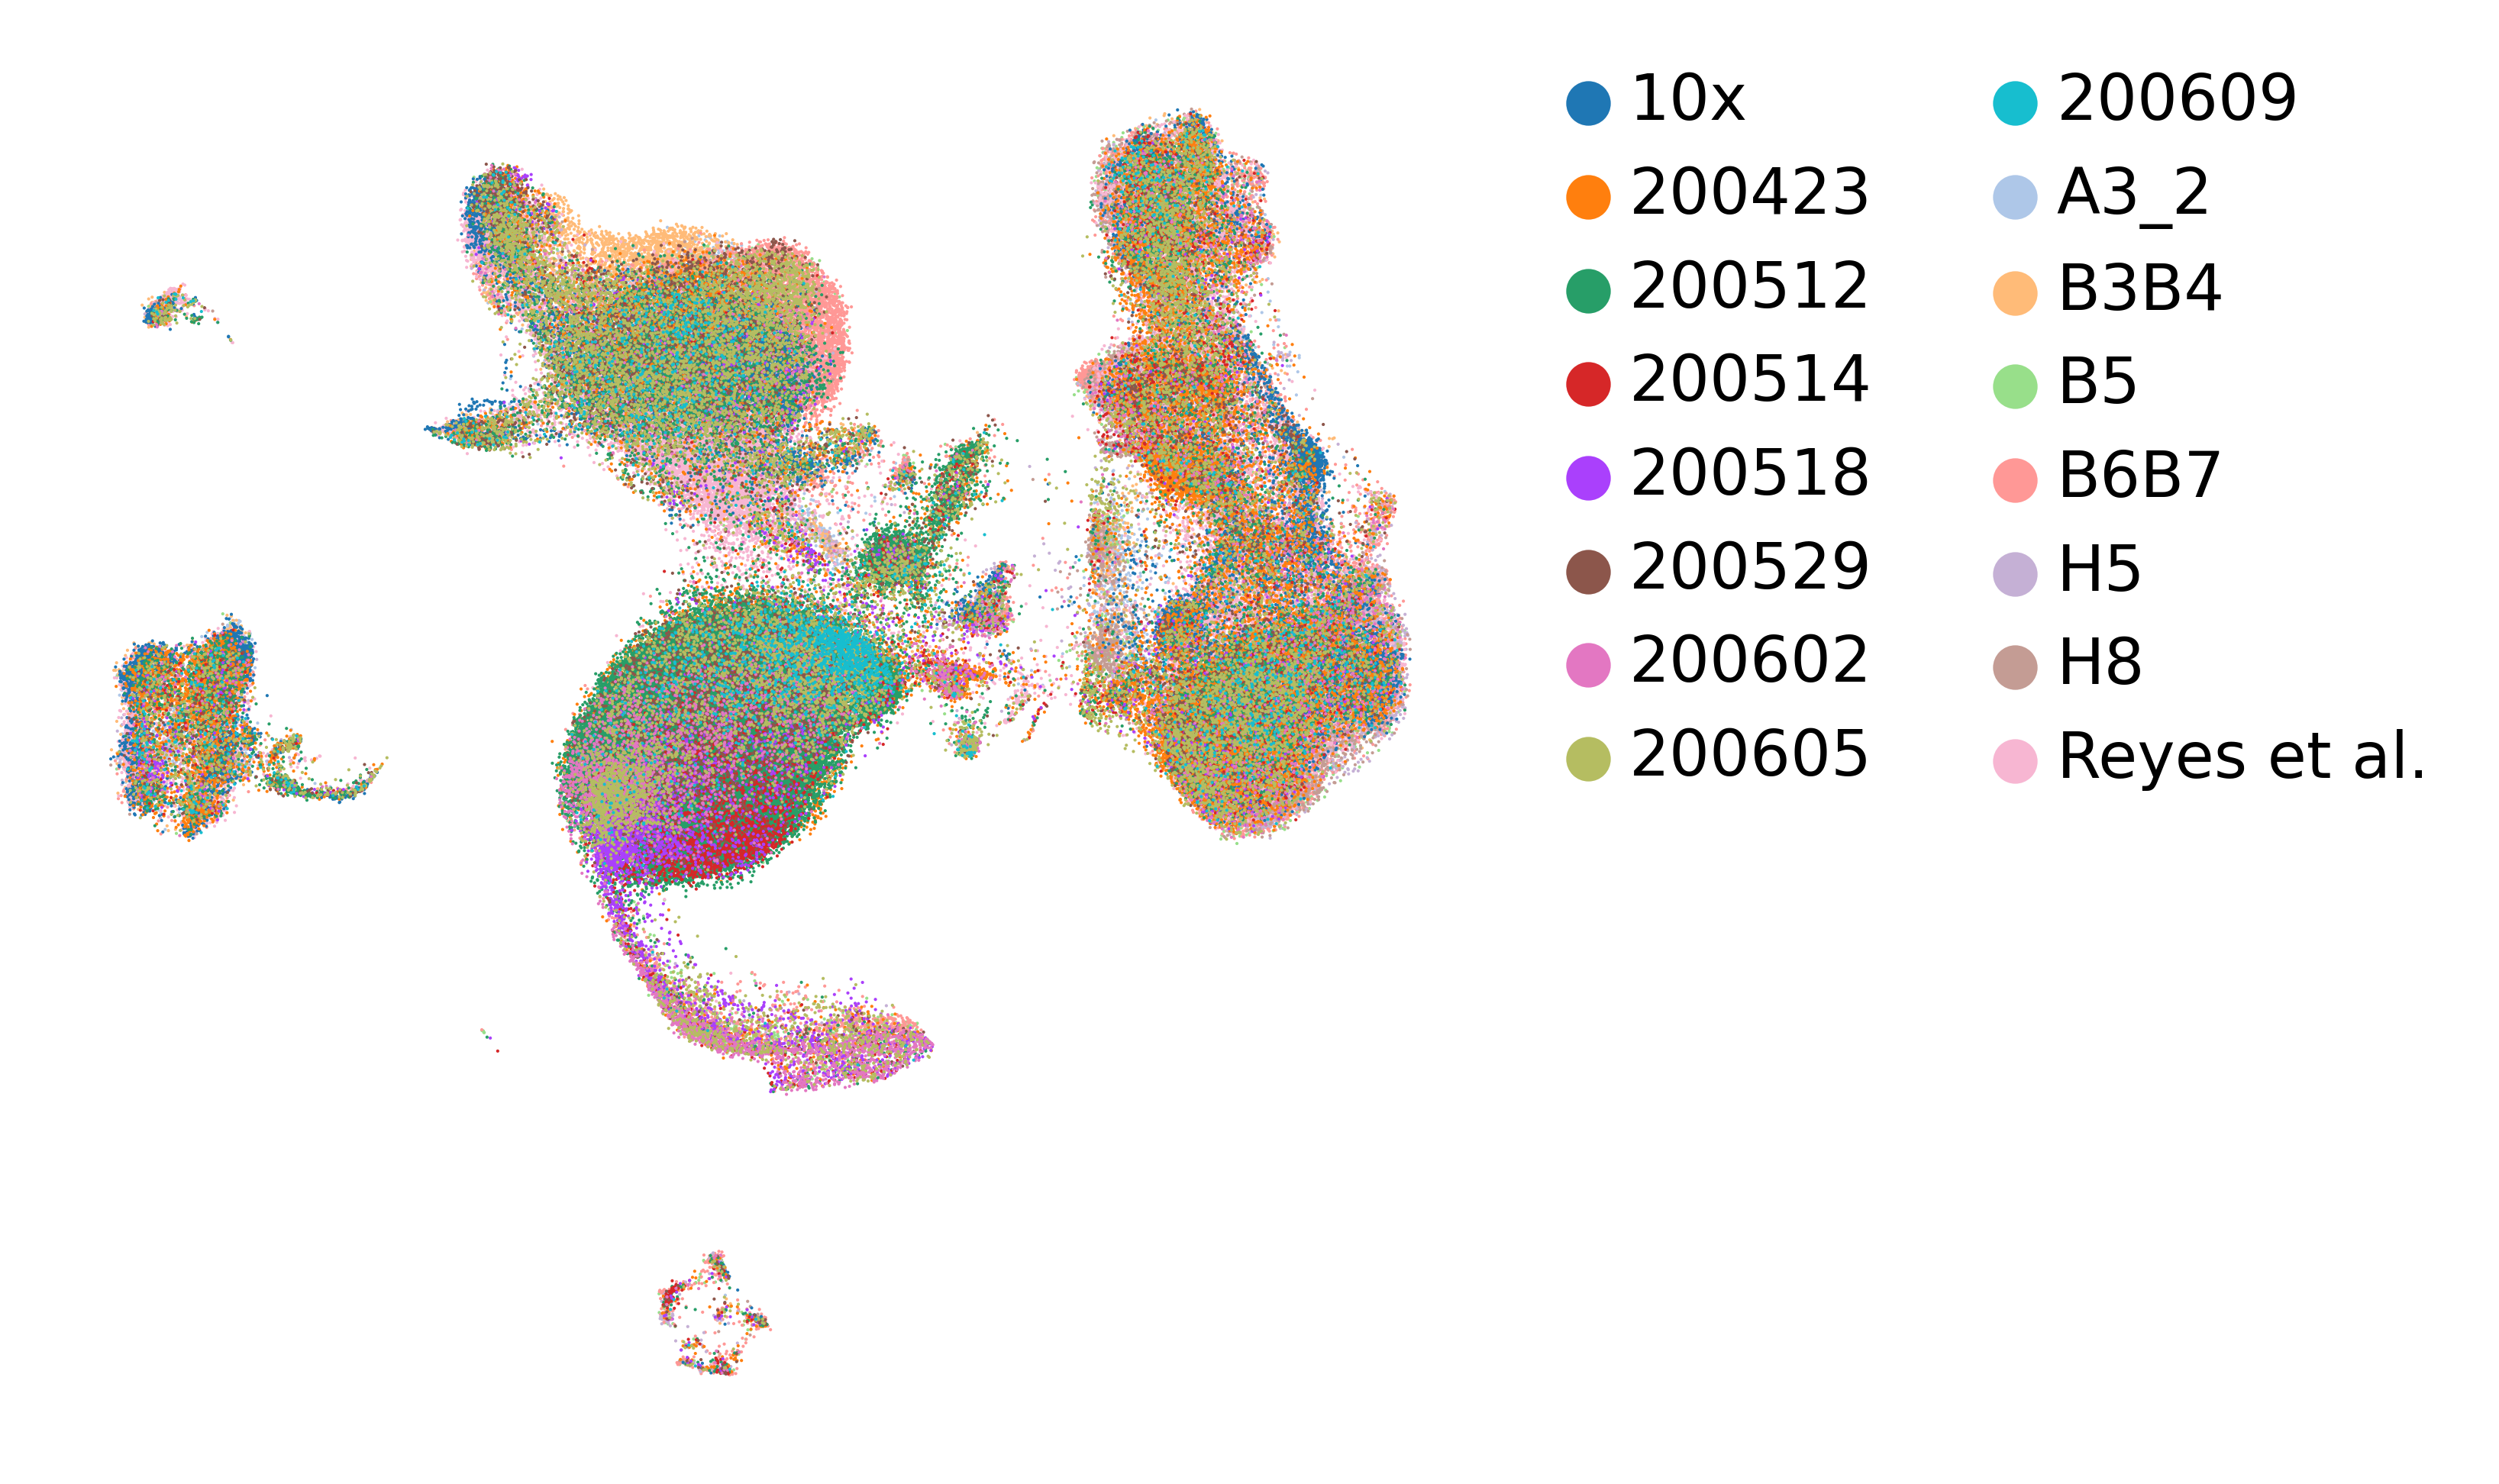

In [16]:
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata, color='experiment', frameon=False, size=1, show=False, ax=ax)
ax.set_title('', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, fontsize=10, borderaxespad=0., frameon=False)
fig.savefig('suschulte/schulte_cell_experiment.png', dpi=500, bbox_inches='tight')

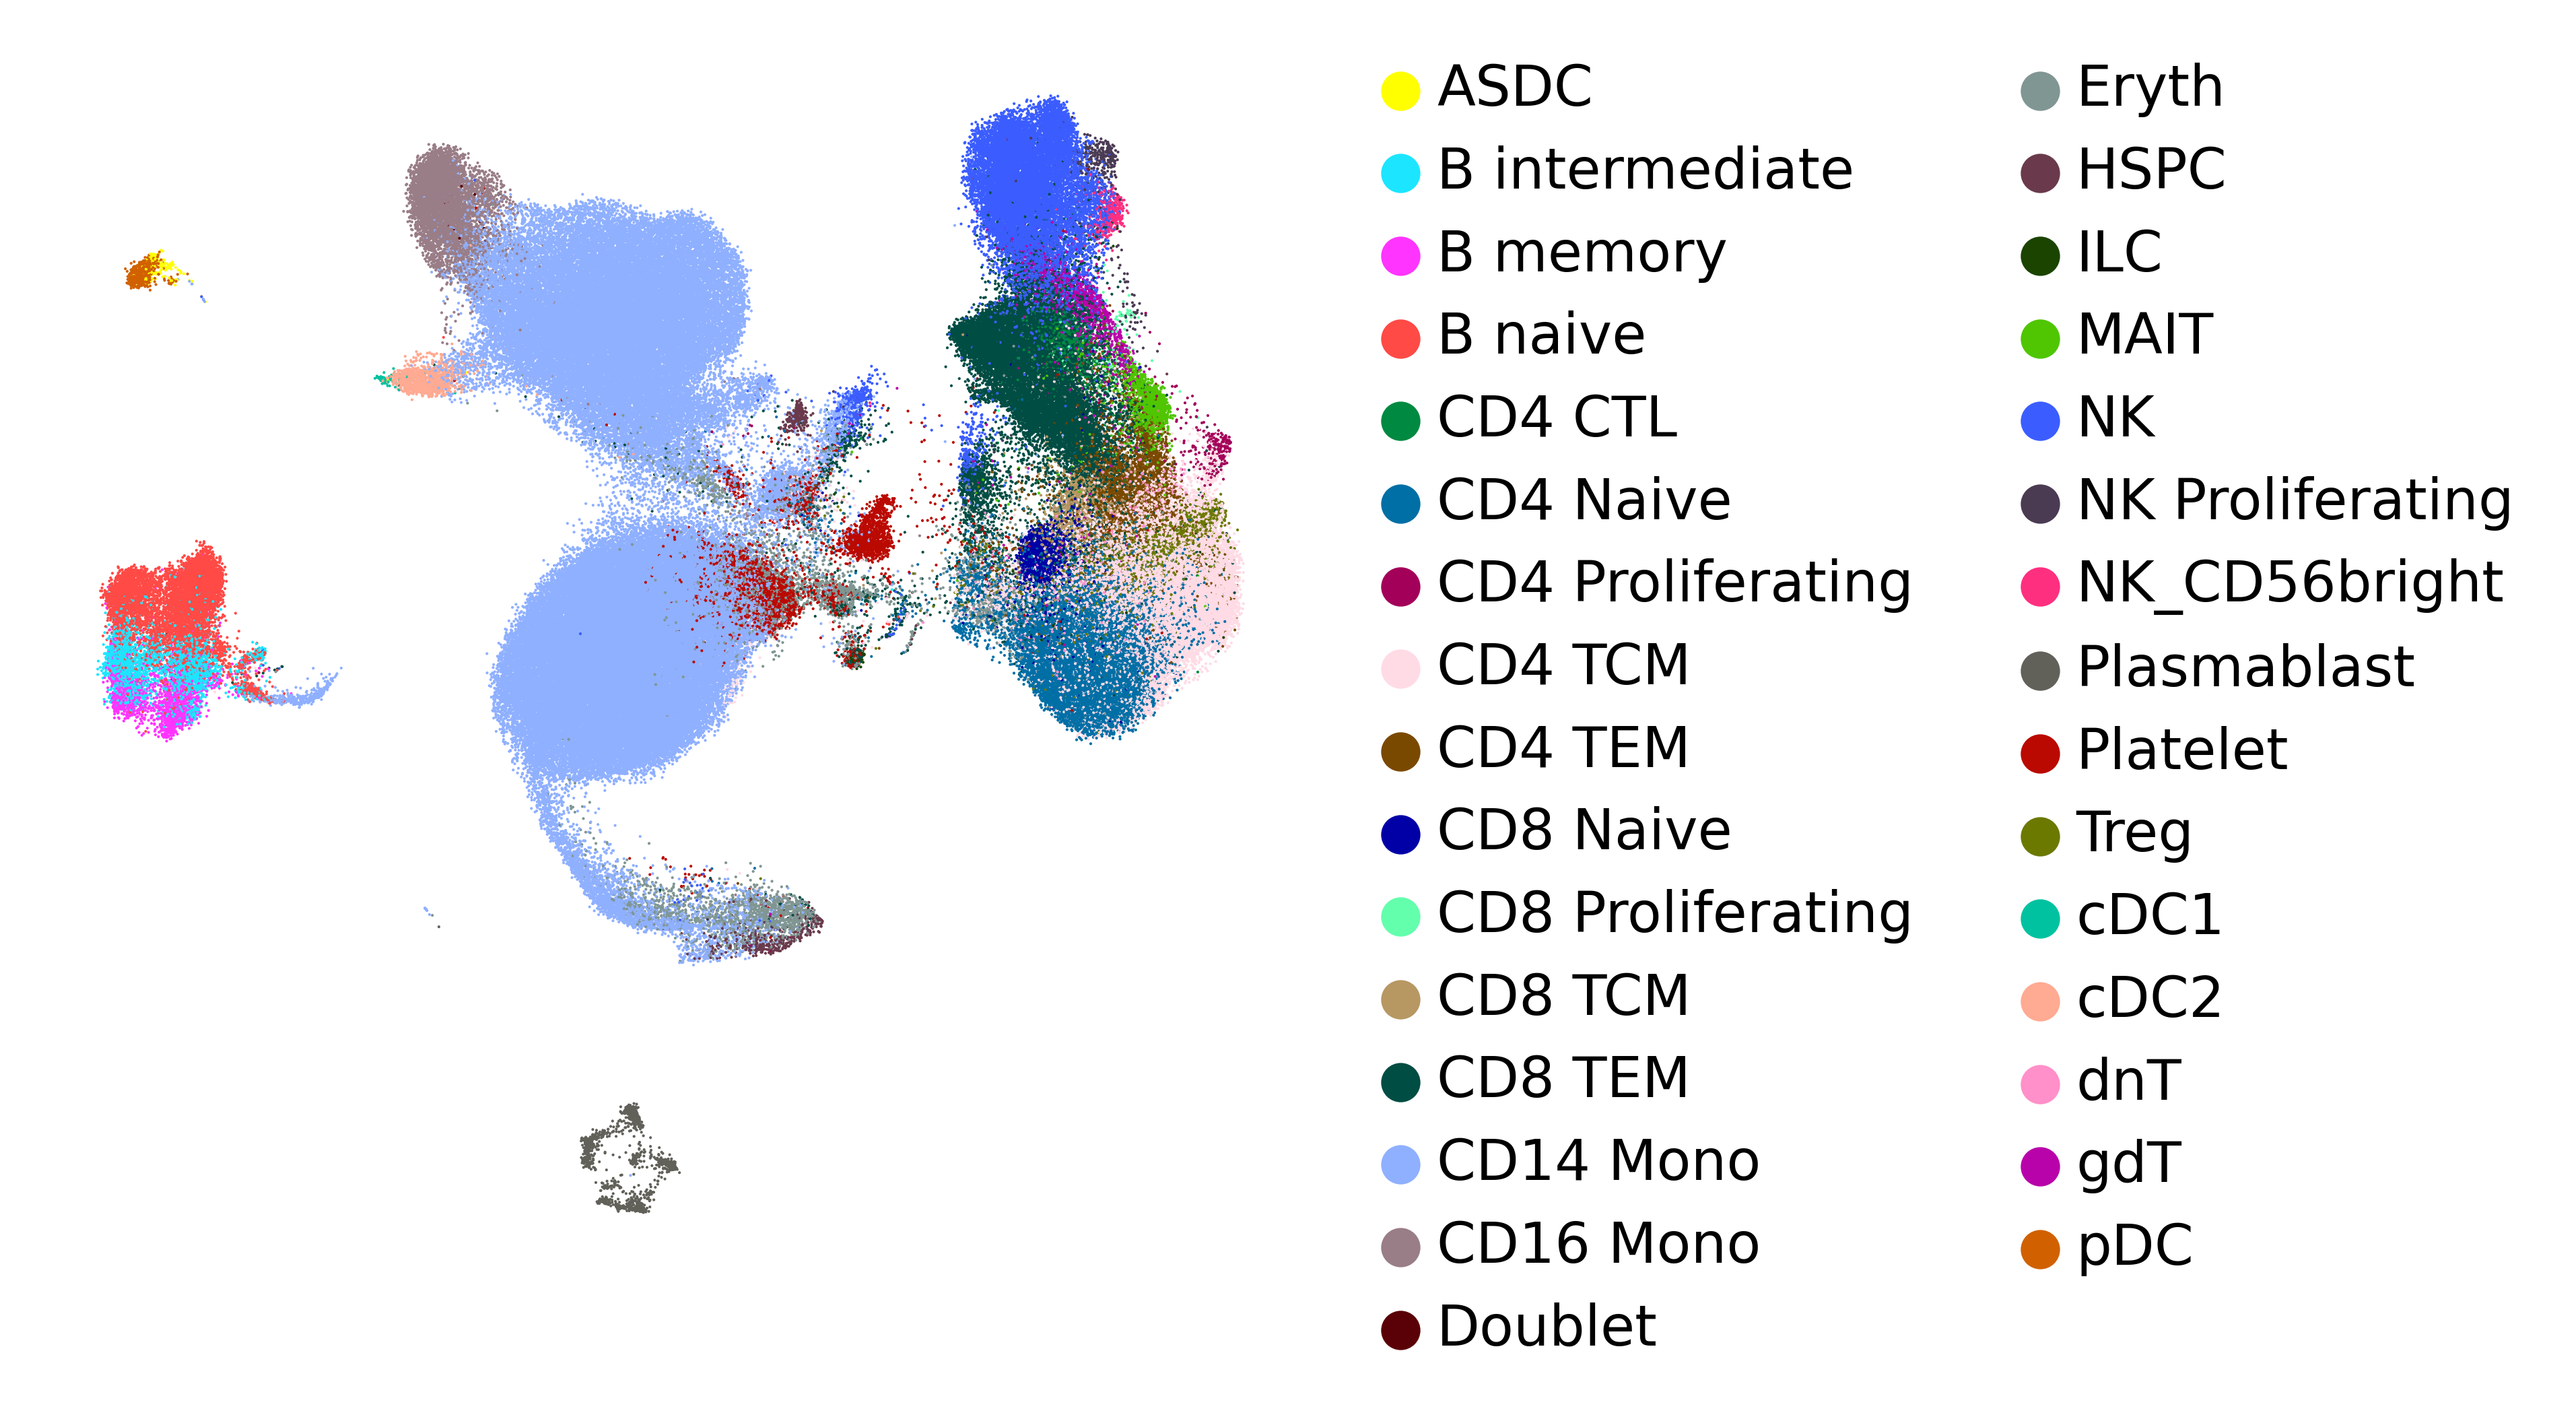

In [17]:
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata, color='cell_type', frameon=False, size=1, show=False, ax=ax)
ax.set_title('', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, fontsize=10, borderaxespad=0., frameon=False)
fig.savefig('suschulte/schulte_cell_ct.png', dpi=500, bbox_inches='tight')

In [11]:
df_scib = pd.read_csv('/lustre/groups/ml01/workspace/hediyehzadeh.s/projects/lataq_pbmc/integration/results/schulte_schrepping_lataq_generic_integration_scib_metrics.csv', index_col=[0])

In [12]:
df_scib['overall'] = df_scib.mean(1)

In [13]:
df_scib['covariate'] = ['sample', 'cohort', 'experiment']

In [14]:
df_scib.columns = ['iLISI', 'cLISI', 'ASW/batch', 'ASW/labels', 'F1 (cell type)', 'Graph connectivity', 'Overall', 'Covariate']

In [15]:
df_melt = pd.melt(df_scib, id_vars='Covariate')
df_melt['Covariate'] = df_melt['Covariate'].astype('category')
df_melt['Covariate'] = df_melt['Covariate'].cat.reorder_categories(['sample', 'experiment', 'cohort'])

In [19]:
df_melt

Covariate            variable     value
0       sample               iLISI  0.391126
1       cohort               iLISI  0.177871
2   experiment               iLISI  0.358863
3       sample               cLISI  0.996371
4       cohort               cLISI  0.996332
5   experiment               cLISI  0.995824
6       sample           ASW/batch  0.897484
7       cohort           ASW/batch  0.906612
8   experiment           ASW/batch  0.909188
9       sample          ASW/labels  0.468093
10      cohort          ASW/labels  0.458633
11  experiment          ASW/labels  0.461204
12      sample      F1 (cell type)  0.500021
13      cohort      F1 (cell type)  0.498695
14  experiment      F1 (cell type)  0.492418
15      sample  Graph connectivity  0.924936
16      cohort  Graph connectivity  0.939594
17  experiment  Graph connectivity  0.929560
18      sample             Overall  0.696339
19      cohort             Overall  0.662956
20  experiment             Overall  0.691176

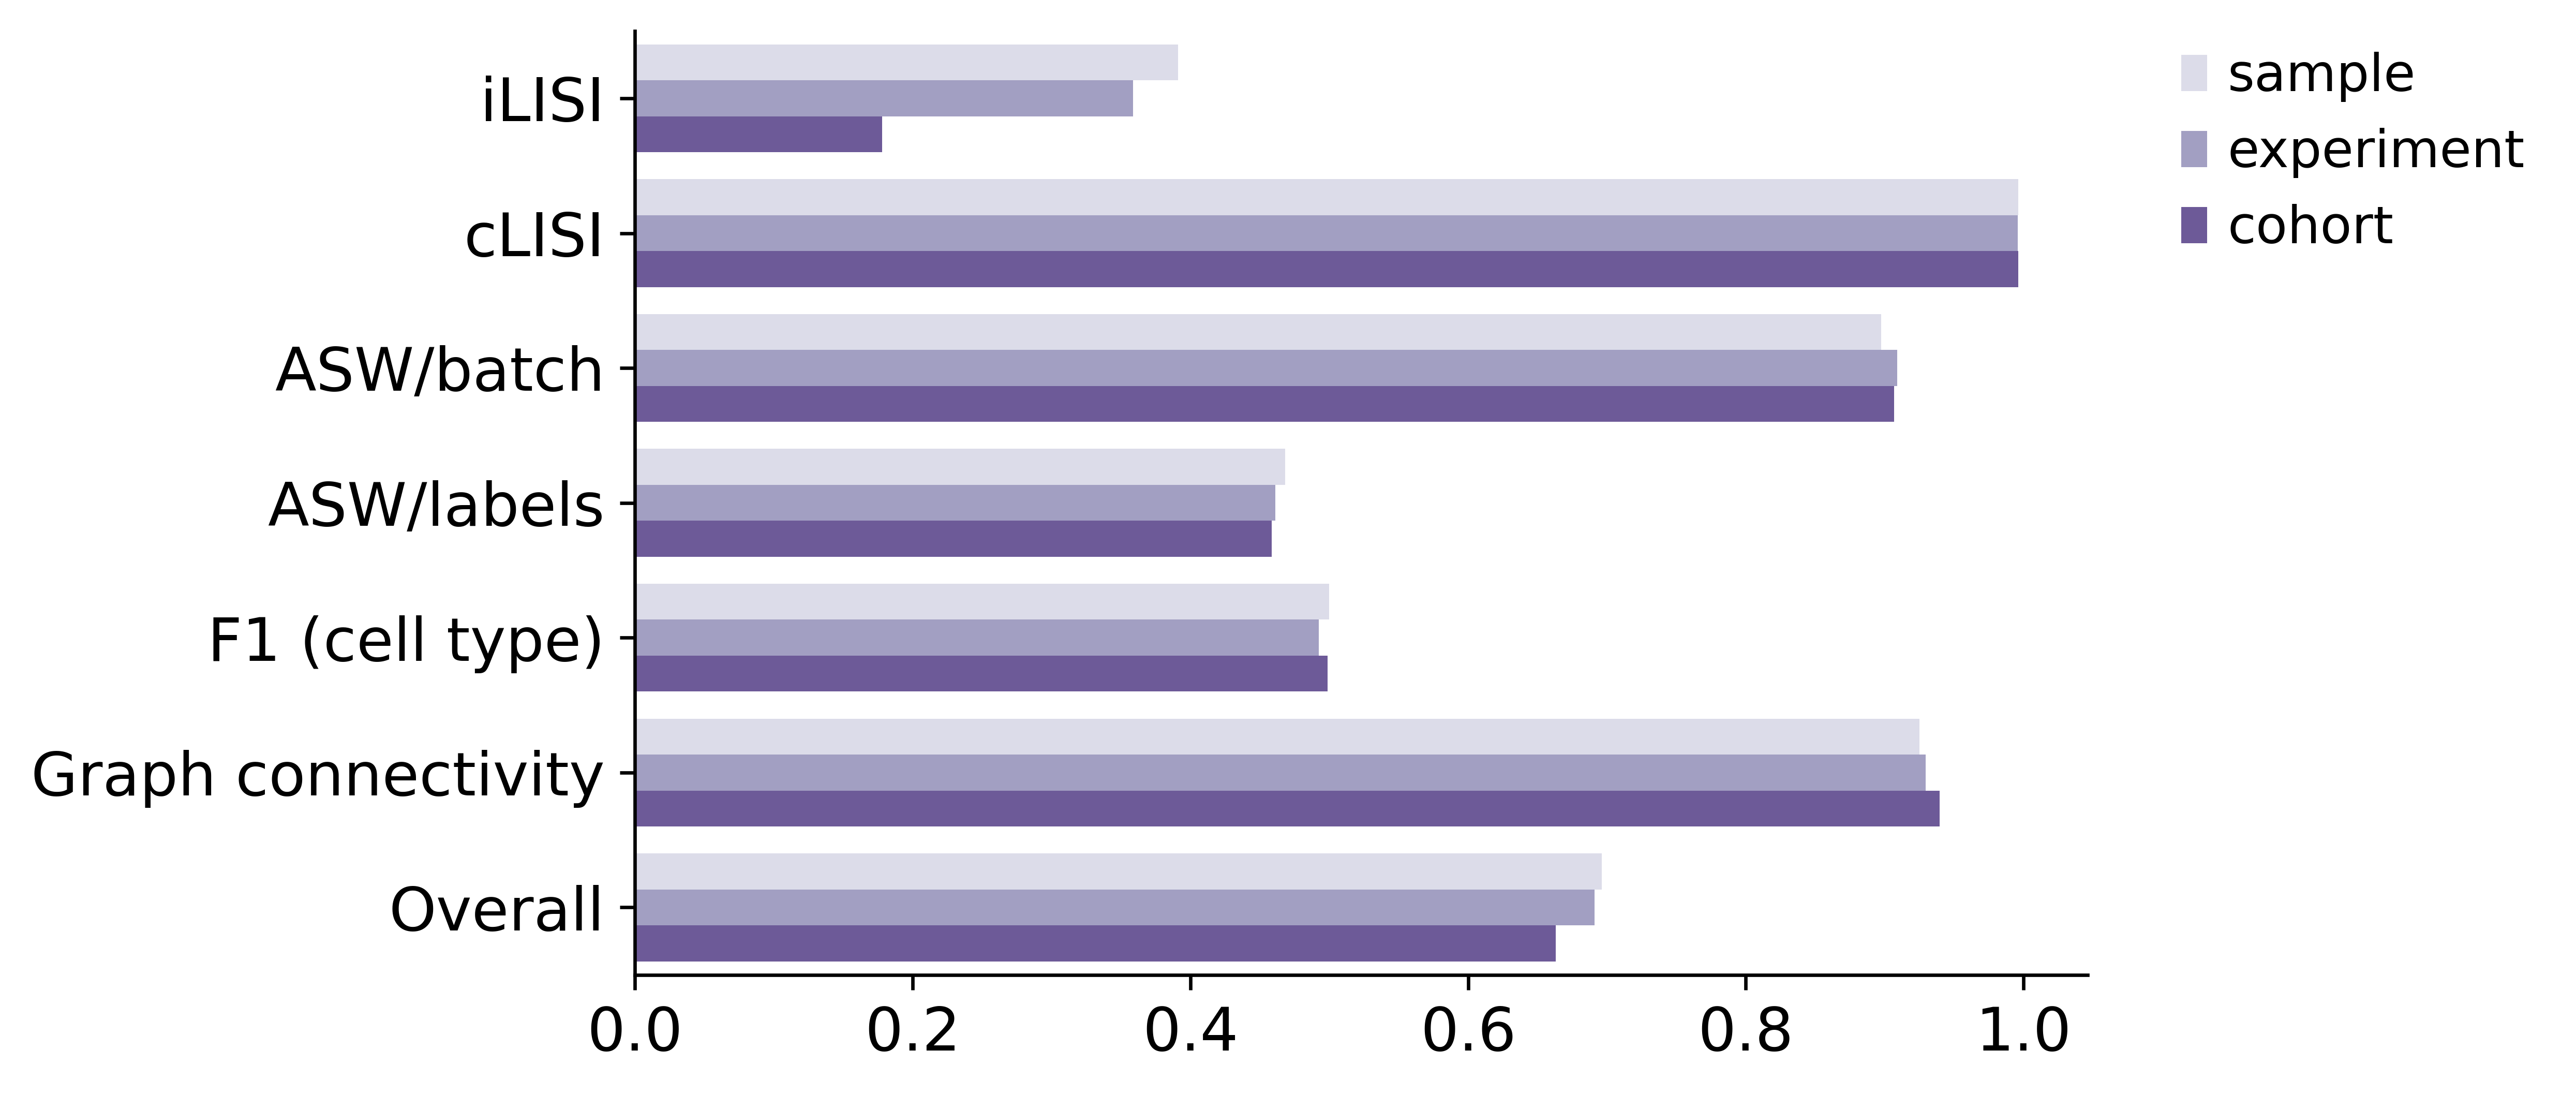

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x='value', y='variable', hue='Covariate', data=df_melt, ax=ax, orientation='horizontal', palette=sns.color_palette("Purples", 3))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1, fontsize=12, borderaxespad=0., frameon=False)
l = ax.get_xticklabels()
ax.grid(False)
sns.despine()
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('suschulte/integration_metrics.png', dpi=400, bbox_inches='tight')
#ax.set_xticklabels(l, rotation=90)

In [27]:
import anndata2ri
import rpy2
from rpy2.robjects import r

sc.settings.set_figure_params(dpi=300, frameon=False)

anndata2ri.activate()
%load_ext rpy2.ipython

In [28]:
adata_emb = sc.read('../data/soroor/schulte_schrepping_embedding.h5ad')
adata_emb

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 99 × 20
    obs: 'sample_type', 'disease_status', 'disease_severity', 'sampleID', 'purification', 'platform', 'experiment', 'cohort'
    uns: 'cohort_colors', 'disease_status_colors', 'experiment_colors', 'pca', 'platform_colors', 'purification_colors', 'sample_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [29]:
obs = adata_emb.obs

In [30]:
%%R -i obs

experiment = obs$experiment
cohort = obs$cohort
disease = obs$disease_status
experiment_n = as.factor(experiment)
cohort_n = as.factor(cohort)
disease_n = as.factor(disease)

In [31]:
pc1_scores = adata_emb.obsm['X_pca'][:,0]
pc2_scores = adata_emb.obsm['X_pca'][:,1]

In [32]:
%%R -i pc1_scores

model <- lm(pc1_scores ~ experiment_n)
print(summary(model))


Call:
lm(formula = pc1_scores ~ experiment_n)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.150106 -0.052745 -0.007991  0.045543  0.251367 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                             -0.057427   0.048465  -1.185  0.23943
experiment_n200423                      -0.319633   0.055258  -5.784 1.25e-07
experiment_n200512                      -0.146941   0.054676  -2.688  0.00870
experiment_n200514                      -0.070027   0.068539  -1.022  0.30989
experiment_n200518                      -0.224600   0.068539  -3.277  0.00153
experiment_n200529                      -0.307147   0.055962  -5.488 4.31e-07
experiment_n200602                      -0.126721   0.064113  -1.977  0.05142
experiment_n200605                      -0.289265   0.056830  -5.090 2.20e-06
experiment_n200609                      -0.372554   0.076629  -4.862 5.44e-06
experiment_nA3_2                        -0.0

In [33]:
%%R -i pc1_scores

model <- lm(pc1_scores ~ cohort_n)
print(summary(model))


Call:
lm(formula = pc1_scores ~ cohort_n)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41852 -0.12059  0.03038  0.09687  0.34886 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.30405    0.02628   11.57   <2e-16 ***
cohort_ncohort2 -0.60201    0.03698  -16.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.184 on 97 degrees of freedom
Multiple R-squared:  0.7321,	Adjusted R-squared:  0.7293 
F-statistic:   265 on 1 and 97 DF,  p-value: < 2.2e-16



In [38]:
%%R -i pc2_scores

model <- lm(pc2_scores ~ cohort_n)
print(summary(model))


Call:
lm(formula = pc2_scores ~ cohort_n)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52723 -0.14205  0.00708  0.23711  0.47422 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)      0.08571    0.04086   2.097  0.03856 * 
cohort_ncohort2 -0.16971    0.05750  -2.951  0.00397 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2861 on 97 degrees of freedom
Multiple R-squared:  0.0824,	Adjusted R-squared:  0.07294 
F-statistic:  8.71 on 1 and 97 DF,  p-value: 0.003967



In [37]:
%%R -i pc2_scores

model <- lm(pc2_scores ~ experiment_n)
print(summary(model))


Call:
lm(formula = pc2_scores ~ experiment_n)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09292 -0.03318 -0.01022  0.02535  0.17526 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                              0.37022    0.02892  12.803  < 2e-16
experiment_n200423                      -0.45886    0.03297 -13.917  < 2e-16
experiment_n200512                      -0.41874    0.03262 -12.836  < 2e-16
experiment_n200514                      -0.34909    0.04090  -8.536 5.53e-13
experiment_n200518                      -0.14784    0.04090  -3.615 0.000514
experiment_n200529                      -0.57885    0.03339 -17.336  < 2e-16
experiment_n200602                      -0.41086    0.03825 -10.740  < 2e-16
experiment_n200605                      -0.53389    0.03391 -15.745  < 2e-16
experiment_n200609                      -0.45063    0.04572  -9.856 1.27e-15
experiment_nA3_2                        -0.15548    0.04090  -3.

In [35]:
%%R -i pc1_scores

model <- lm(pc1_scores ~ disease_n)
print(summary(model))


Call:
lm(formula = pc1_scores ~ disease_n)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50099 -0.30046 -0.08568  0.34859  0.62363 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)      -0.02440    0.04822  -0.506    0.614
disease_nhealthy  0.05368    0.07153   0.751    0.455

Residual standard error: 0.3544 on 97 degrees of freedom
Multiple R-squared:  0.005773,	Adjusted R-squared:  -0.004476 
F-statistic: 0.5633 on 1 and 97 DF,  p-value: 0.4548



In [34]:
%%R -i pc2_scores

model <- lm(pc2_scores ~ disease_n)
print(summary(model))


Call:
lm(formula = pc2_scores ~ disease_n)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40255 -0.19807  0.01156  0.14195  0.62735 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.17363    0.03111   5.582 2.16e-07 ***
disease_nhealthy -0.38198    0.04614  -8.279 6.83e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2286 on 97 degrees of freedom
Multiple R-squared:  0.414,	Adjusted R-squared:  0.408 
F-statistic: 68.54 on 1 and 97 DF,  p-value: 6.83e-13



In [42]:
adata_emb.obs['experiment'] = adata_emb.obs['experiment'].astype(str)
adata_emb.obs['experiment'][adata_emb.obs['experiment'].str.contains("Reyes")] = 'Reyes et al.'

<ipython-input-42-9bd0bd28db08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_emb.obs['experiment'][adata_emb.obs['experiment'].str.contains("Reyes")] = 'Reyes et al.'


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


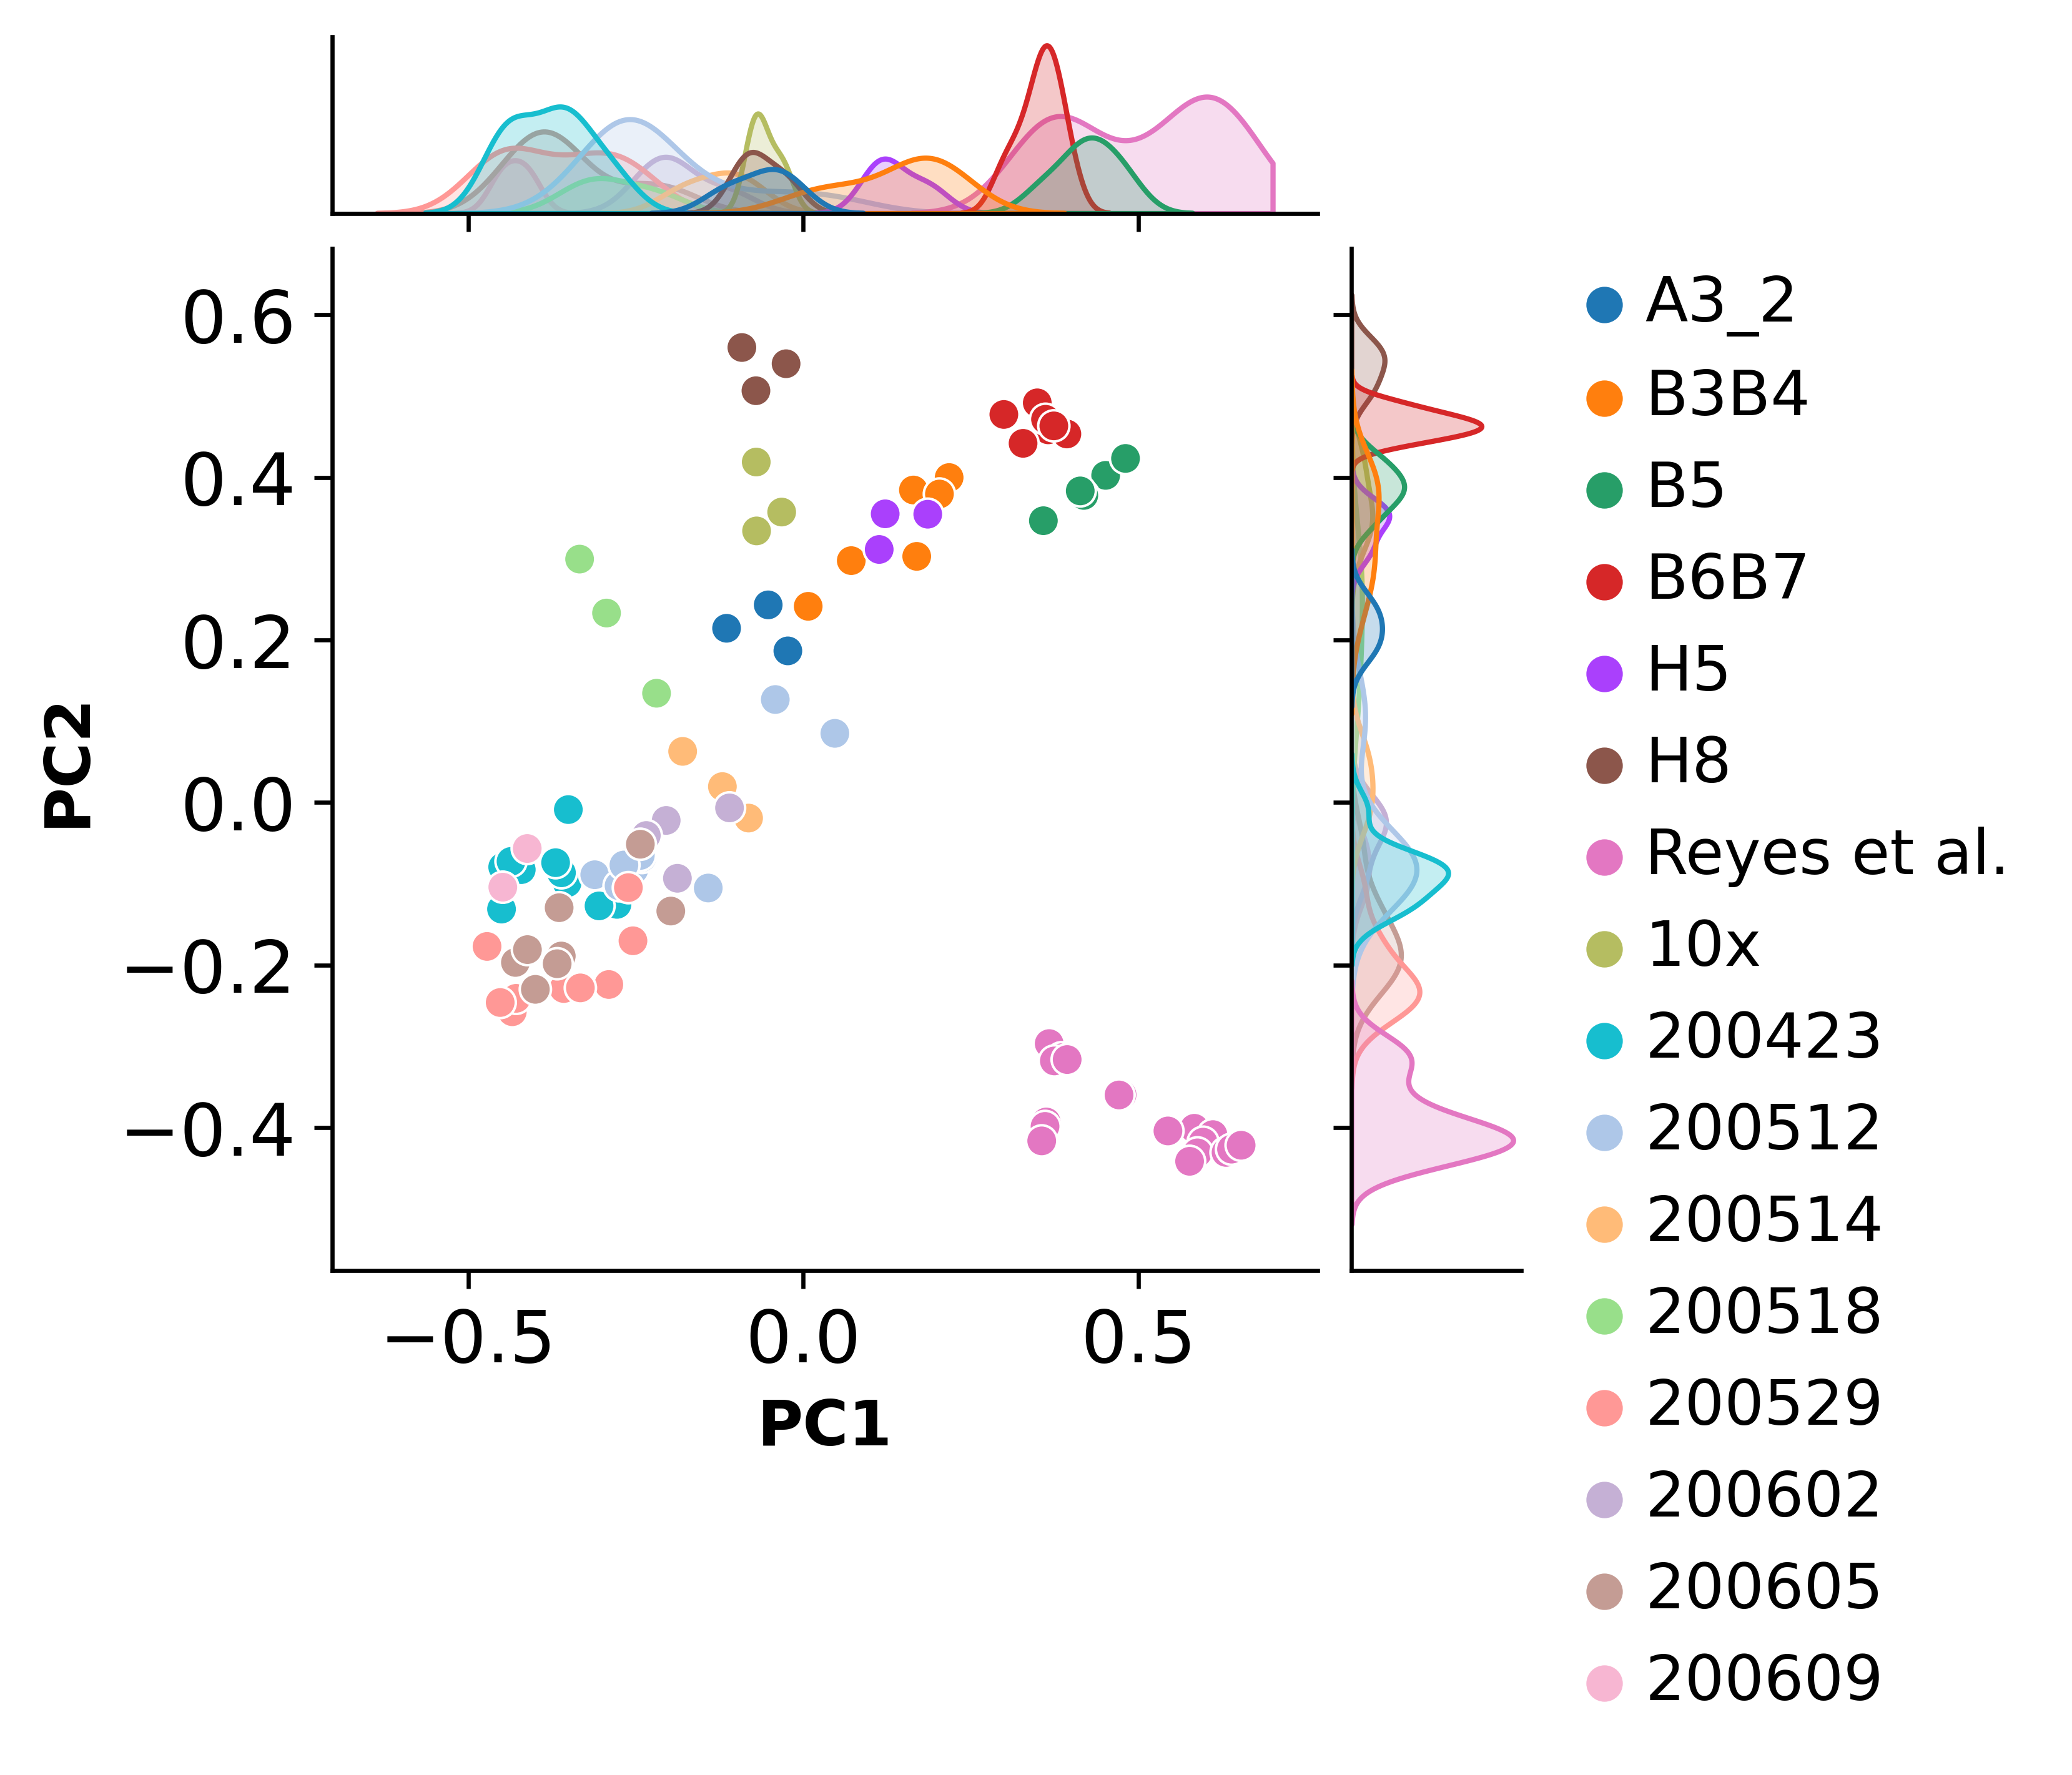

In [43]:
embedding_plot_adata(adata_emb, 'experiment', [0, 1], bound=0.7, study_filename='schulte')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


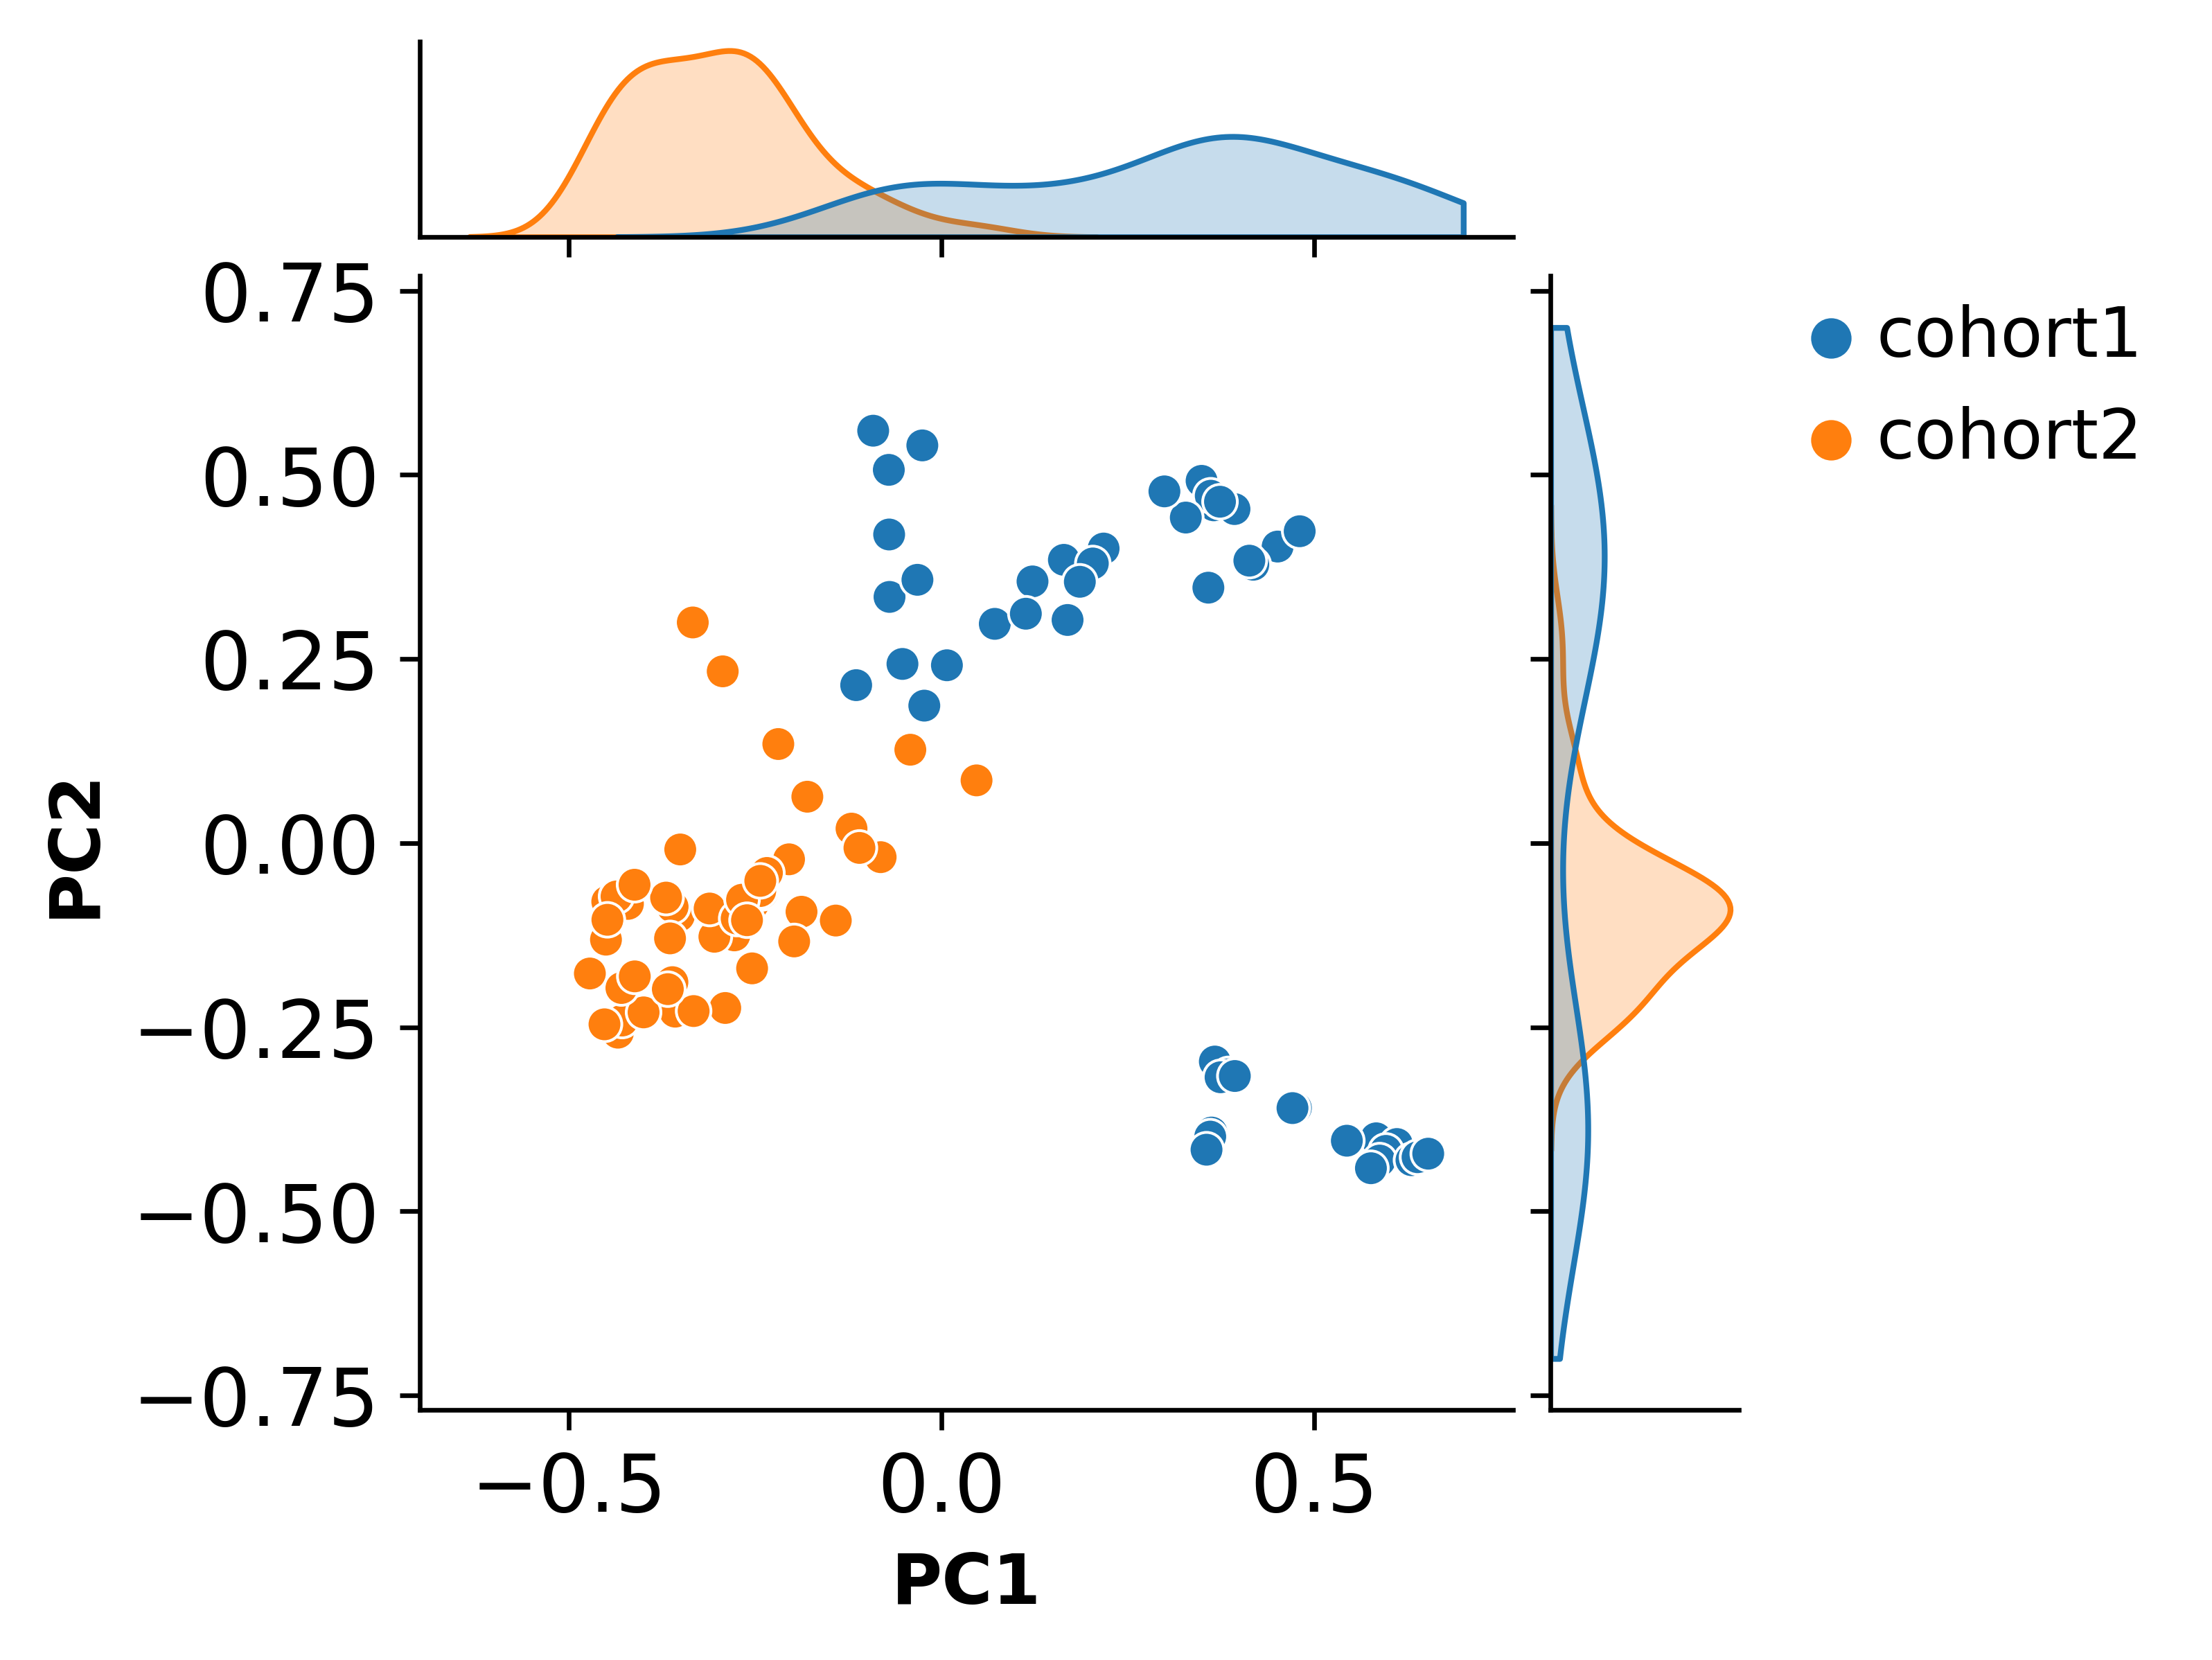

In [44]:
embedding_plot_adata(adata_emb, 'cohort', [0, 1], bound=0.7, study_filename='schulte')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


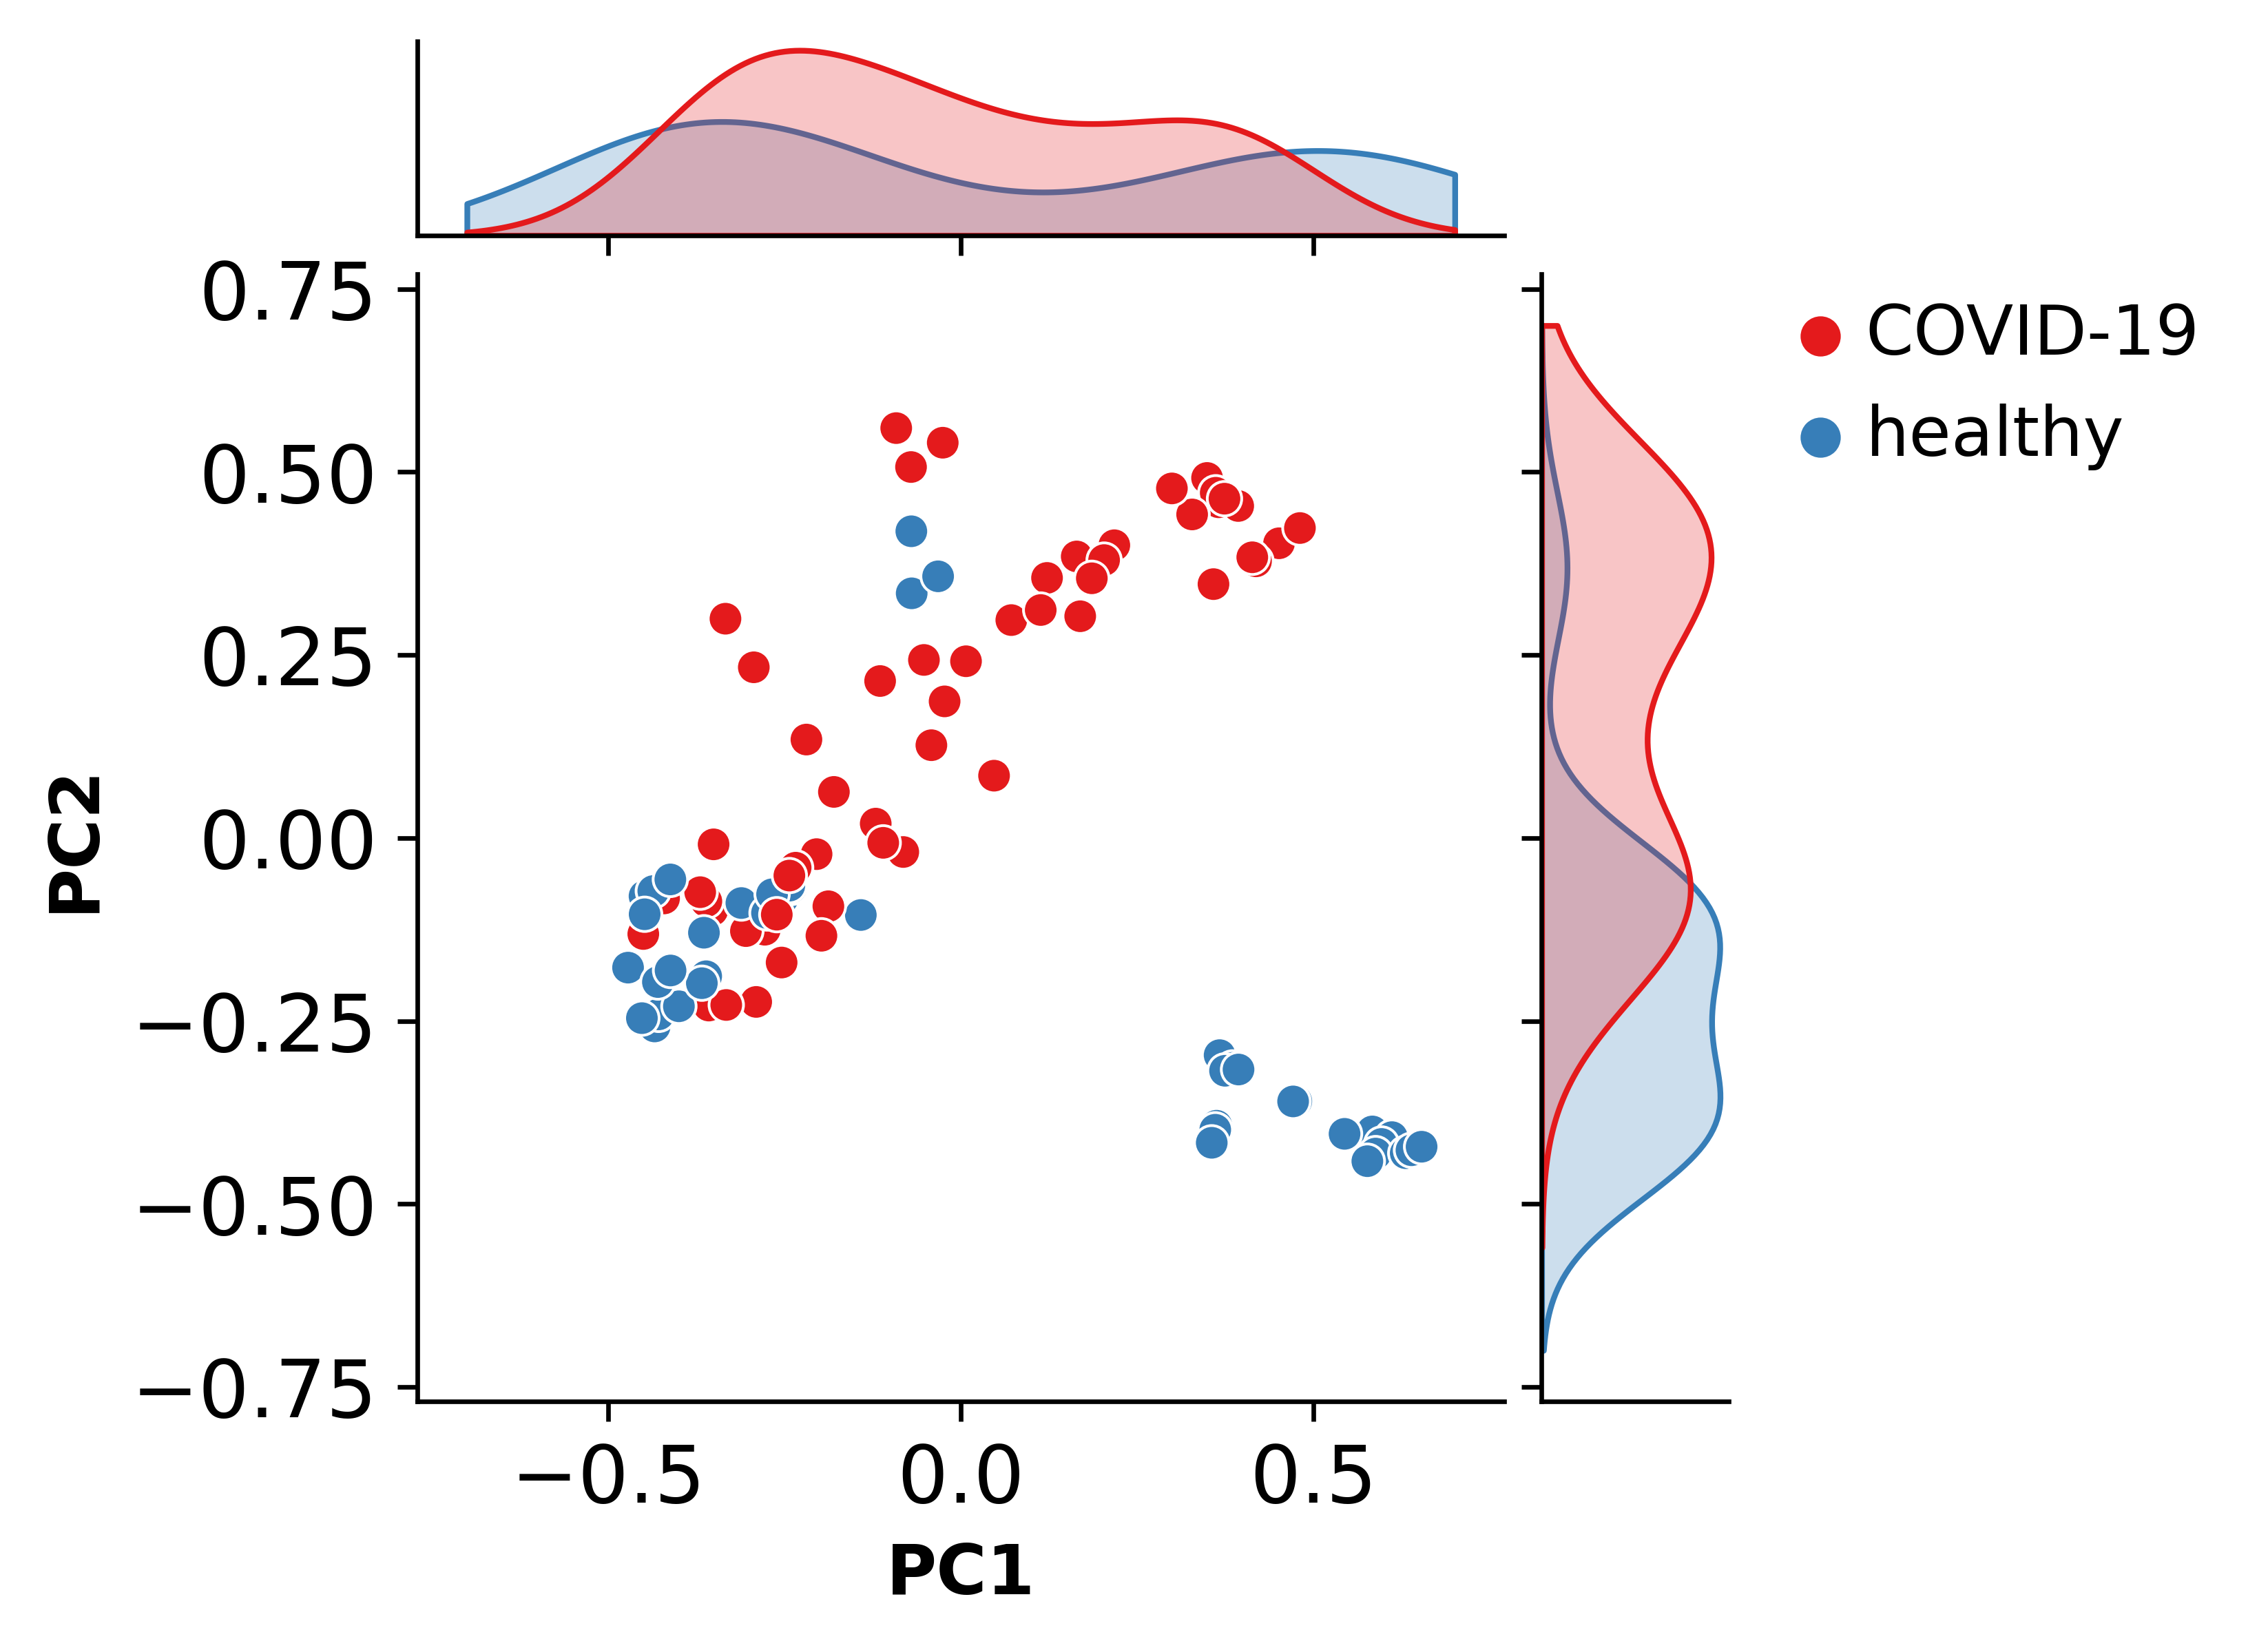

In [45]:
embedding_plot_adata(adata_emb, 'disease_status', [0, 1], bound=0.7, palette=sns.color_palette('Set1')[:2], study_filename='schulte')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


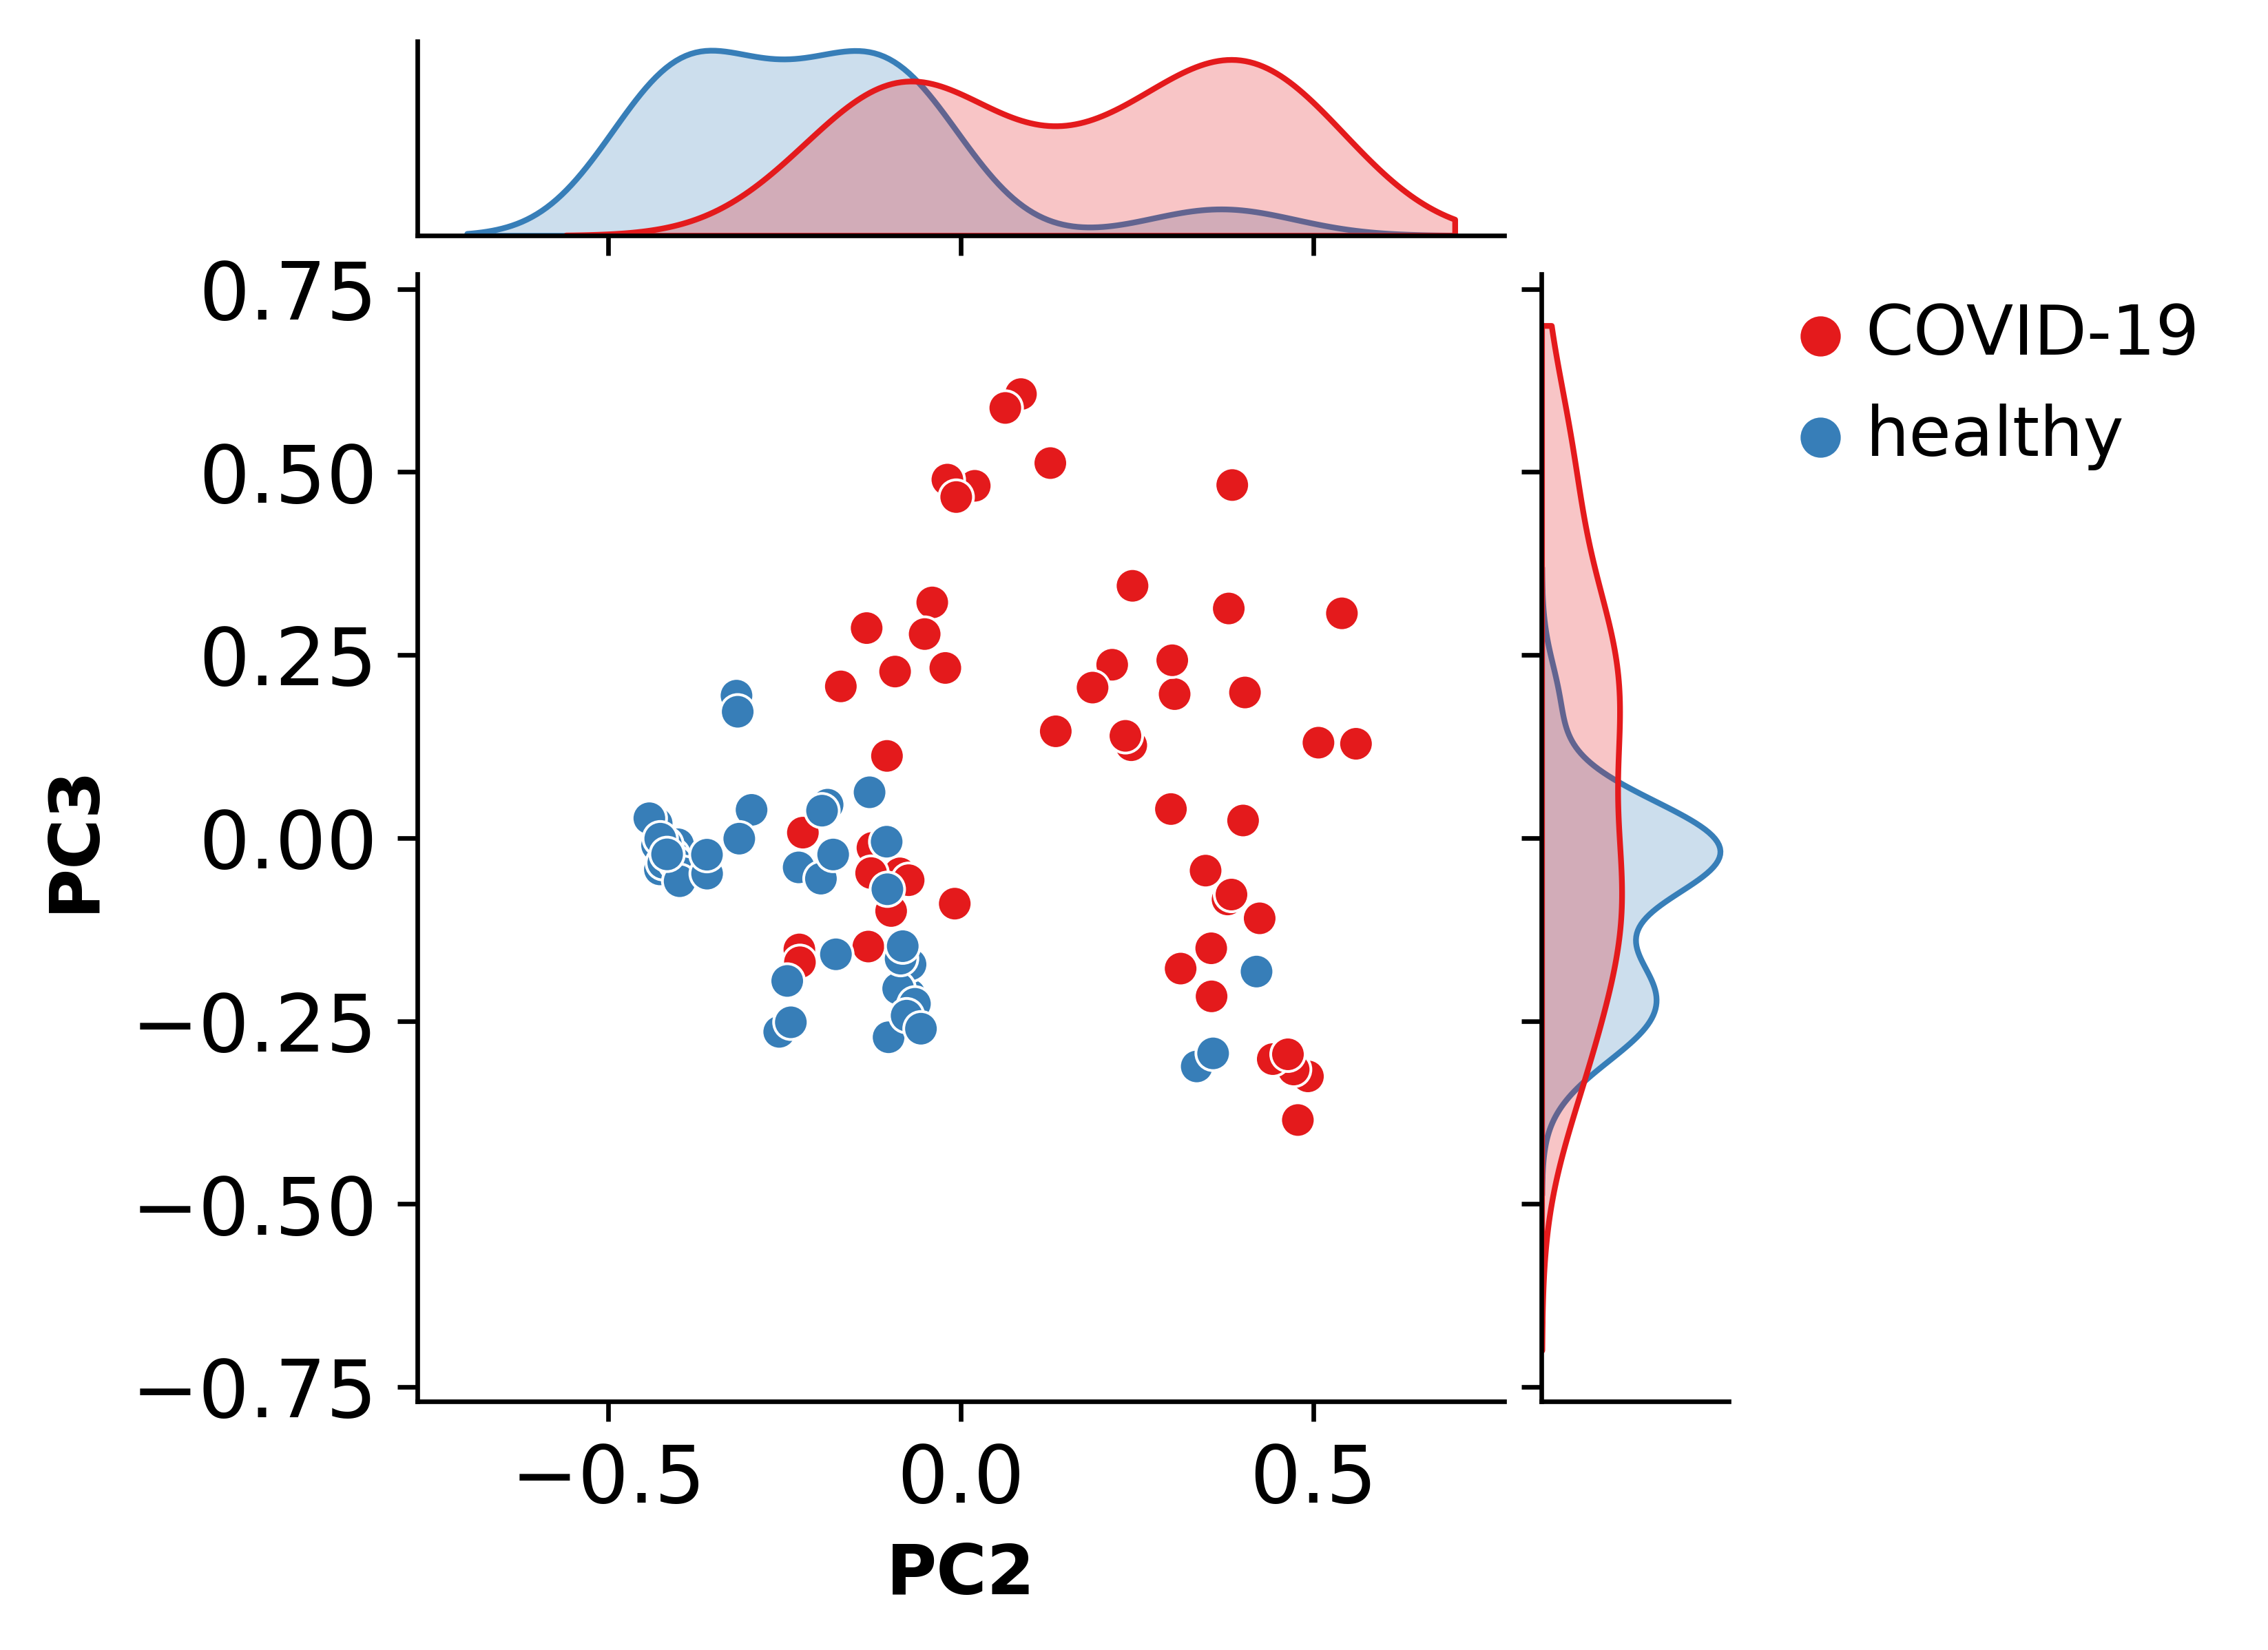

In [46]:
embedding_plot_adata(adata_emb, 'disease_status', [1, 2], bound=0.7, palette=sns.color_palette('Set1')[:2], study_filename='schulte')